## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

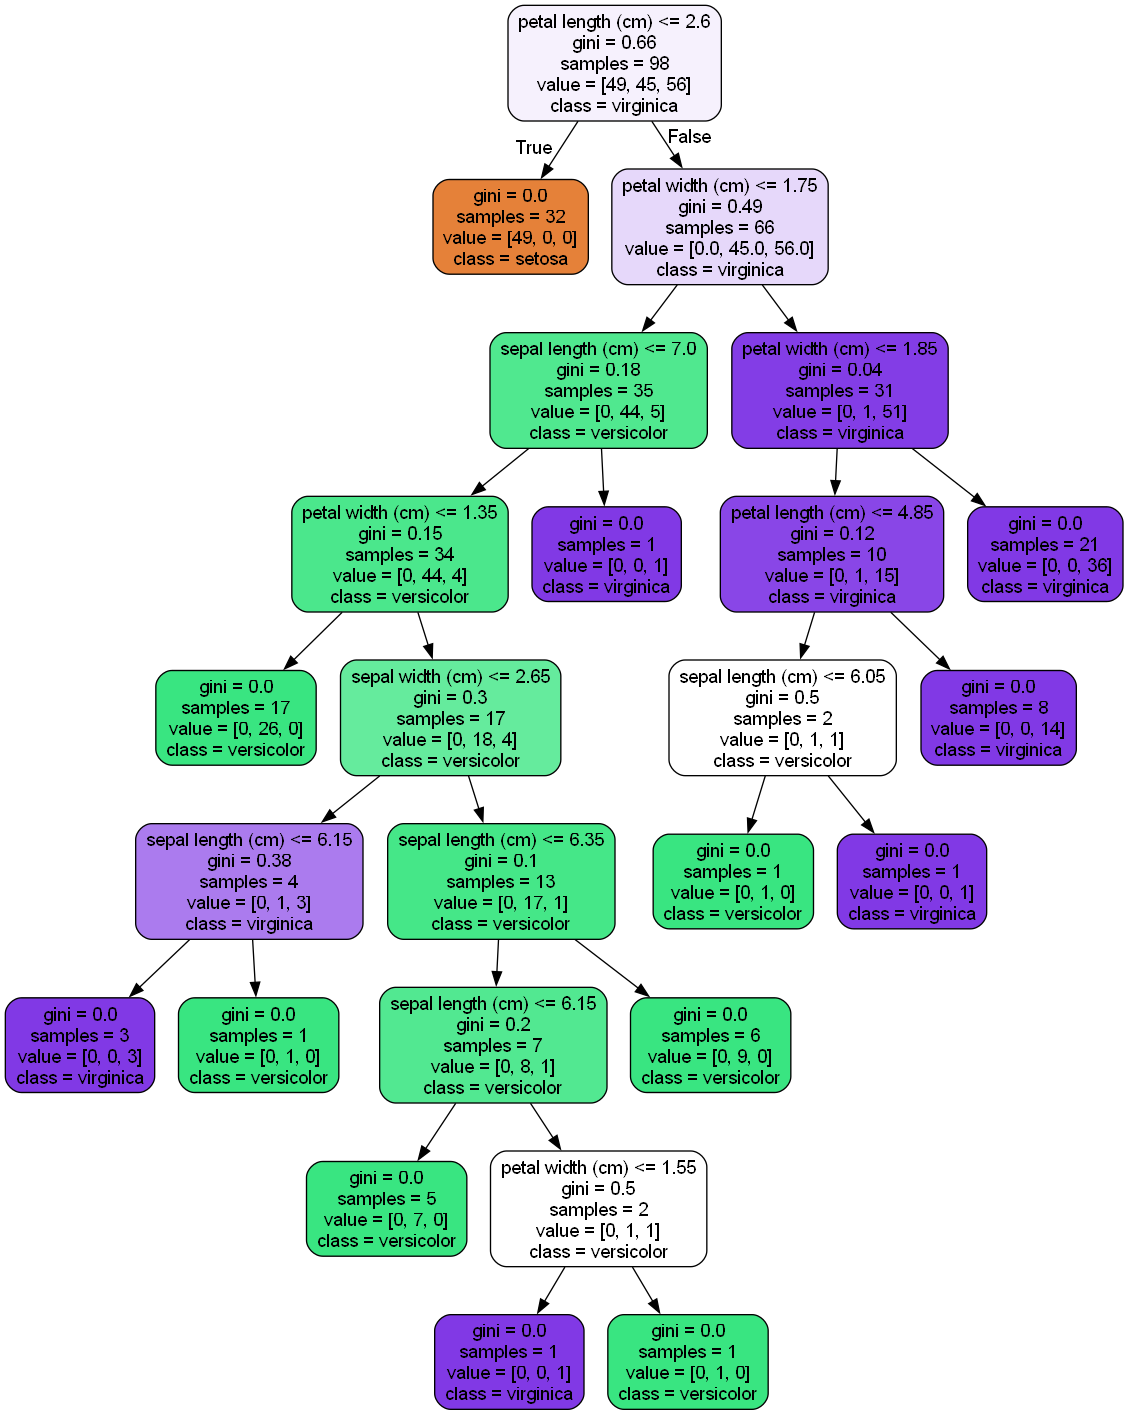

In [34]:
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris

iris = load_iris()
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model.fit(iris.data, iris.target)
estimator = model.estimators_[5]
export_graphviz(estimator, out_file='tree.dot',
                feature_names=iris.feature_names,
                class_names=iris.target_names,
                rounded=True, proportion=False,
                precision=2, filled=True)
from subprocess import call

call(['C:/Program Files/Graphviz/bin/dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gd pi=600'])
from IPython.display import Image

Image(filename='tree.png')

Notice how each split separates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [35]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [36]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head(100)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1000000096,4645.0,male,1982.0,30s,Korea,Seoul,Dobong-gu,NaN,etc,NaN,NaN,NaN,2020-03-01,2020-03-02,NaN,NaN,isolated
96,1000000097,4709.0,male,1985.0,30s,Korea,Seoul,Yangcheon-gu,NaN,contact with patient,NaN,NaN,NaN,NaN,2020-03-01,NaN,NaN,isolated
97,1000000098,4743.0,male,1966.0,50s,Korea,Seoul,Seocho-gu,NaN,etc,NaN,NaN,NaN,NaN,2020-03-02,NaN,NaN,isolated
98,1000000099,5377.0,female,1996.0,20s,Korea,Seoul,Dongdaemun-gu,NaN,etc,NaN,NaN,NaN,NaN,2020-03-01,NaN,NaN,isolated


In [37]:
df.shape

(2218, 18)

In [38]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [39]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [40]:
import pandas as pd
from datetime import datetime

# Create a new column named 'n_age' which is the calculated age based on the birth year column
current_year = datetime.now().year
df['n_age'] = current_year - df['birth_year']

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [41]:
print(df.isnull().sum())

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64


In [42]:
df.info()# Assuming df is your DataFrame


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [43]:
# Fill NaN with 0
df['disease'].fillna(0, inplace=True)

# Remap True to 1 and False to 0
df['disease'] = df['disease'].map({True: 1, False: 0})

C:\Users\adlik\AppData\Local\Temp\ipykernel_30600\4271920480.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['disease'].fillna(0, inplace=True)


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [44]:
# List of columns to fill
columns_to_fill = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']

# Fill NaN with column mean
for column in columns_to_fill:
    df[column].fillna(df[column].mean(), inplace=True)

C:\Users\adlik\AppData\Local\Temp\ipykernel_30600\4091713880.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [17]:
print(df.isnull().sum())

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64


In [45]:
# Find columns with some NaN values
nan_columns = df.columns[df.isnull().any()].tolist()

print(nan_columns)

['sex', 'age', 'city', 'infection_case', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date', 'state', 'n_age']


In [47]:
# Filling missing values with appropriate methods

# Fill categorical missing values with mode (most frequent value)
df['sex'].fillna("Unknown", inplace=True)
df['age'].fillna("Unknown", inplace=True)
df['city'].fillna("Unknown", inplace=True)
df['state'].fillna("Unknown", inplace=True)

df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,61.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,38.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,61.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,34.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,33.0


 **<font color='teal'> Check for any remaining null values.</font>**

In [48]:
print(df.isnull().sum())

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                  454
dtype: int64


In [49]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,61.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,38.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,61.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,34.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,33.0


Remove date columns from the data.


In [50]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [51]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   3
birth_year           97
age                  12
country               4
province             17
city                135
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                96
dtype: int64


Review the percent of unique values by column.

In [52]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.001353
birth_year         0.043733
age                0.005410
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043282
dtype: float64


Review the range of values per column.

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,1764.0,5.001134e+01,1.941264e+01,5.000000e+00,3.200000e+01,5.050000e+01,6.300000e+01,1.090000e+02


### Check for duplicated rows

In [54]:
duplicated_rows = df.duplicated()
print("Number of duplicate rows: ", duplicated_rows.sum())

Number of duplicate rows:  0


Print the categorical columns and their associated levels.

In [55]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,3
1,age,12
2,country,4
3,province,17
4,city,135
5,infection_case,16
6,state,4


In [56]:
def age_to_mean(age_group):
    if age_group == '50s':
        return 55
    # Add all other age_groups here
    elif age_group == '0s':
        return 5
    elif age_group == '10s':
        return 15
    elif age_group == '20s':
        return 25
    elif age_group == '30s':
        return 35
    elif age_group == '40s':
        return 45
    elif age_group == '60s':
        return 65
    elif age_group == '70s':
        return 75
    elif age_group == '80s':
        return 85
    elif age_group == '90s':
        return 95
    else:
        return None  # or some default value


# Assuming 'age_group' is the column with these values
# Also assuming df and df['age'] is defined
df['age'] = df['age'].apply(age_to_mean)

In [57]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is a pandas DataFrame and 'gender' is the column with values 'male' and 'female'
labelencoder = LabelEncoder()
dfo['sex'] = labelencoder.fit_transform(dfo['sex'])

# 'male' might be 0 and 'female' might be 1

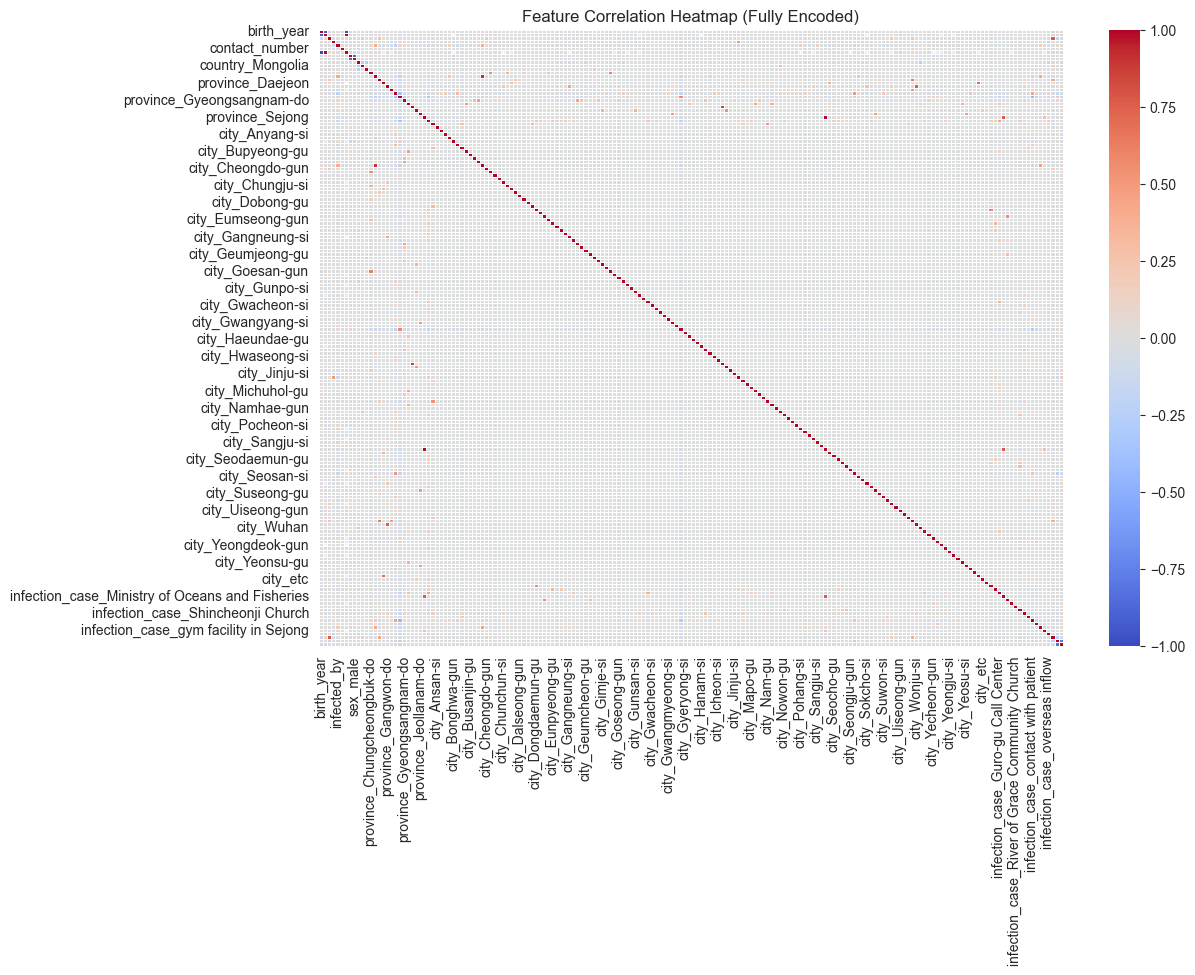

In [58]:
# Ensure categorical columns are properly one-hot encoded, including 'sex'
df_encoded = df.drop(columns=['patient_id', 'global_num'])

# Re-identify categorical columns for encoding
categorical_cols = ['sex', 'country', 'province', 'city', 'infection_case', 'state']

# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Fully Encoded)")
plt.show()


In [59]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,55.0,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,61.0
1,1000000002,5.0,male,1987.0,35.0,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,38.0
2,1000000003,6.0,male,1964.0,55.0,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,61.0
3,1000000004,7.0,male,1991.0,25.0,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,34.0
4,1000000005,9.0,female,1992.0,25.0,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,33.0


In [60]:
df.columns


Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

**<font color='teal'> Plot the correlation heat map for the features.</font>**

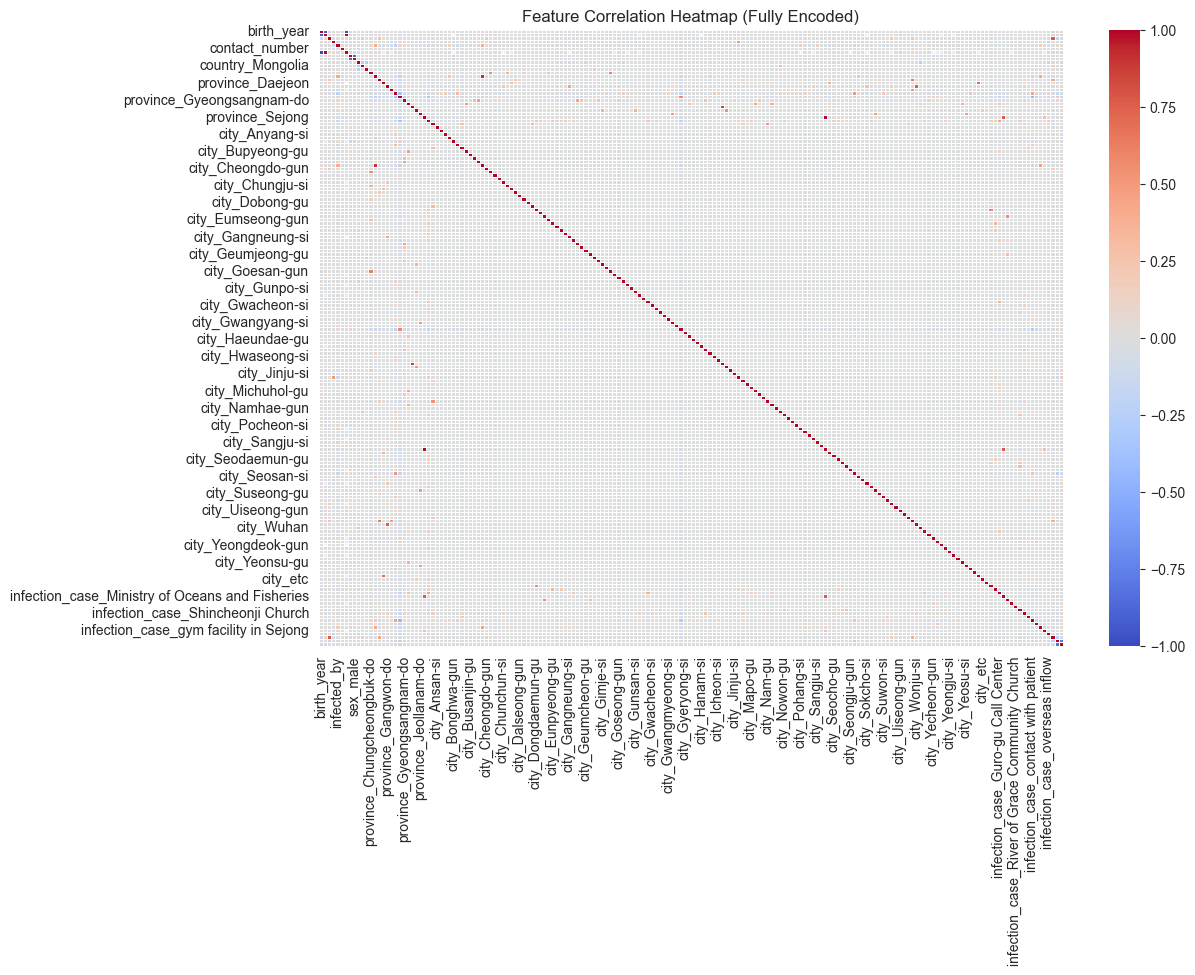

In [61]:
# Ensure categorical columns are properly one-hot encoded, including 'sex'
df_encoded = df.drop(columns=['patient_id', 'global_num'])

# Re-identify categorical columns for encoding
categorical_cols = ['sex', 'country', 'province', 'city', 'infection_case', 'state']

# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Fully Encoded)")
plt.show()


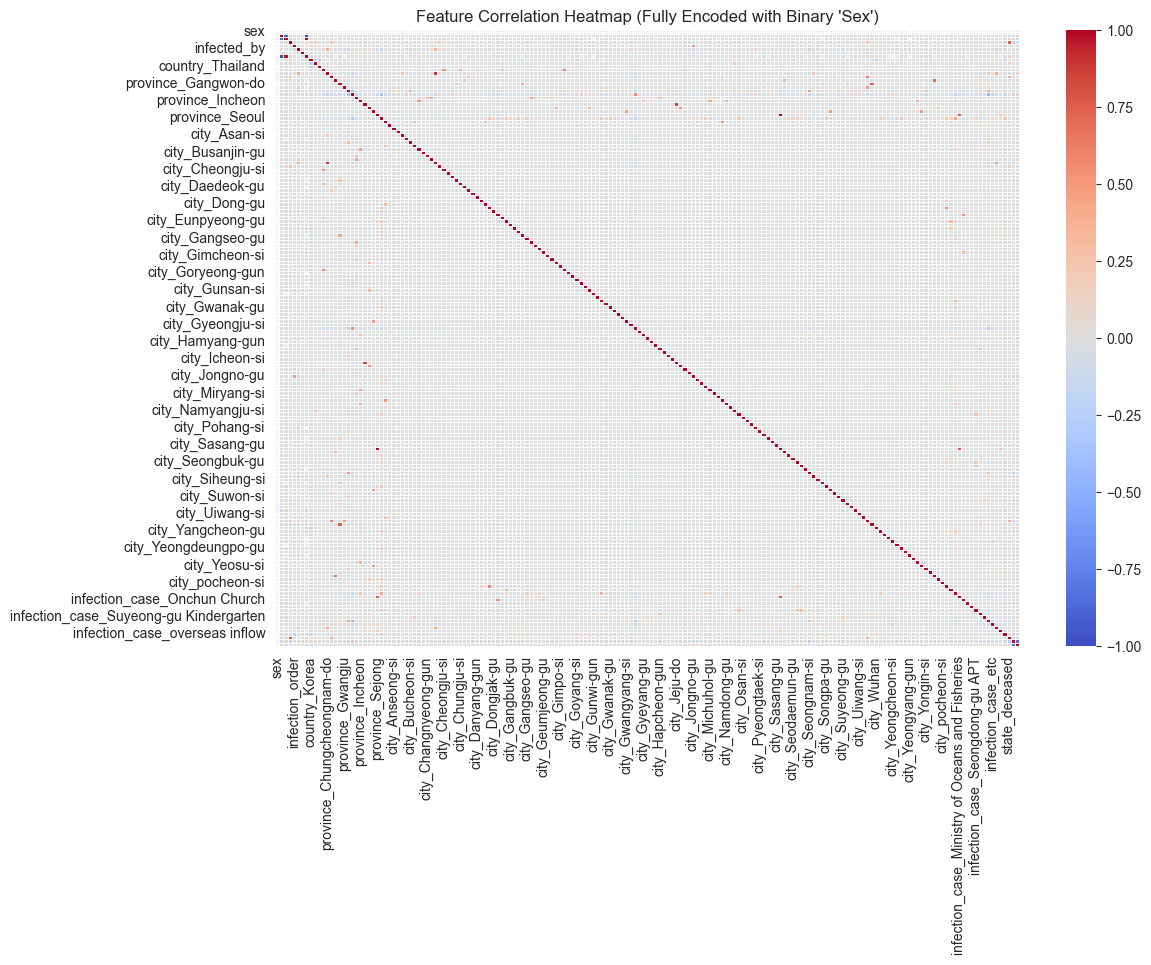

In [62]:
# Ensure 'sex' is properly encoded before correlation computation
df_encoded = df.drop(columns=['patient_id', 'global_num'])

# Convert 'sex' to binary encoding (M → 1, F → 0) before one-hot encoding other categorical variables
df_encoded['sex'] = df_encoded['sex'].map({'M': 1, 'F': 0})

# Re-identify categorical columns excluding 'sex' (already encoded)
categorical_cols = ['country', 'province', 'city', 'infection_case', 'state']

# Apply one-hot encoding to remaining categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Compute the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Fully Encoded with Binary 'Sex')")
plt.show()


**<font color='teal'> Plot the boxplots to check for outliers. </font>**

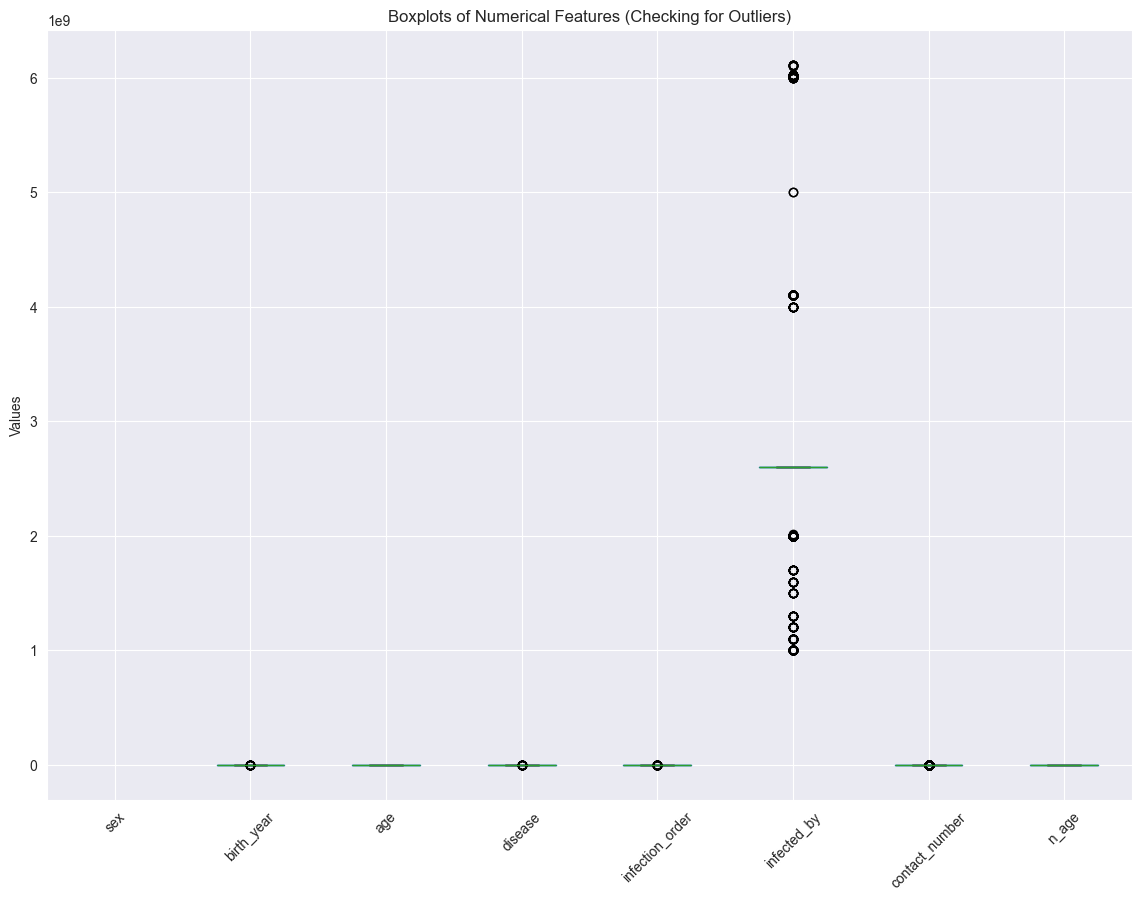

In [63]:
# Plot boxplots for numerical features to check for outliers
numeric_cols = df_encoded.select_dtypes(include=['number']).columns

# Create boxplots for each numeric column
plt.figure(figsize=(14, 10))
df_encoded[numeric_cols].boxplot(rot=90)  # Rotate labels for better readability

plt.title("Boxplots of Numerical Features (Checking for Outliers)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()


**<font color='teal'> Create dummy features for object type features. </font>**

In [64]:
# Identify object (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display the updated dataset with dummy features
df_encoded


,patient_id,global_num,birth_year,age,disease,infection_order,infected_by,contact_number,n_age,sex_female,...,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,state_deceased,state_isolated,state_released
0,1000000001,2.000000,1964.0,55.0,0,1.000000,2.600789e+09,75.000000,61.0,False,...,False,False,False,False,False,False,True,False,False,True
1,1000000002,5.000000,1987.0,35.0,0,1.000000,2.600789e+09,31.000000,38.0,False,...,False,False,False,False,False,False,True,False,False,True
2,1000000003,6.000000,1964.0,55.0,0,2.000000,2.002000e+09,17.000000,61.0,False,...,False,False,True,False,False,False,False,False,False,True
3,1000000004,7.000000,1991.0,25.0,0,1.000000,2.600789e+09,9.000000,34.0,False,...,False,False,False,False,False,False,True,False,False,True
4,1000000005,9.000000,1992.0,25.0,0,2.000000,1.000000e+09,2.000000,33.0,True,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,4664.816591,1990.0,35.0,0,2.285714,2.600789e+09,24.128954,35.0,False,...,False,False,False,False,False,False,False,False,False,False
2214,7000000001,139.000000,1998.0,25.0,0,2.285714,2.600789e+09,87.000000,27.0,False,...,False,False,False,True,False,False,False,False,True,False
2215,7000000002,222.000000,1998.0,25.0,0,2.285714,2.600789e+09,84.000000,27.0,True,...,False,False,False,True,False,False,False,False,False,True
2216,7000000003,4345.000000,1972.0,45.0,0,2.285714,2.600789e+09,21.000000,53.0,True,...,False,False,False,True,False,False,False,False,False,True


### Split the data into test and train subsamples

In [65]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
# 'disease' is the target variable
X = df_encoded.drop(columns=['disease'])  # Features
y = df_encoded['disease']  # Target

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

# Display the shape of the train and test sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



((1774, 181), (444, 181), (1774,), (444,))

### Scale data to prep for model creation

In [66]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.991
Random Forest: f1-score=0.989


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particularly helpful when you have unbalanced class sizes.

In [77]:
class_names=['isolated','released','missing','deceased'] # name  of classes
class_names2=['state_isolated','state_released','state_missing','state_deceased'] # name  of classes

Confusion matrix, without normalization
[[439   1]
 [  3   1]]
Normalized confusion matrix
[[0.997727 0.002273]
 [0.75     0.25    ]]


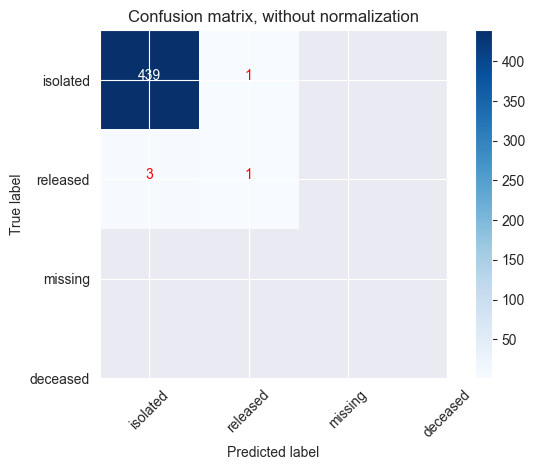

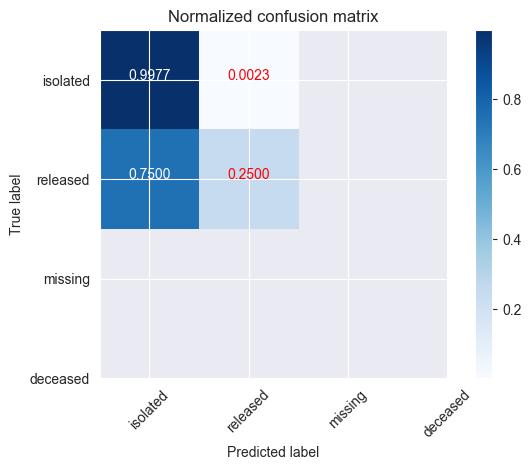

In [85]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=6)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Confusion matrix, without normalization
[[439   1]
 [  3   1]]
Normalized confusion matrix
[[0.997727 0.002273]
 [0.75     0.25    ]]


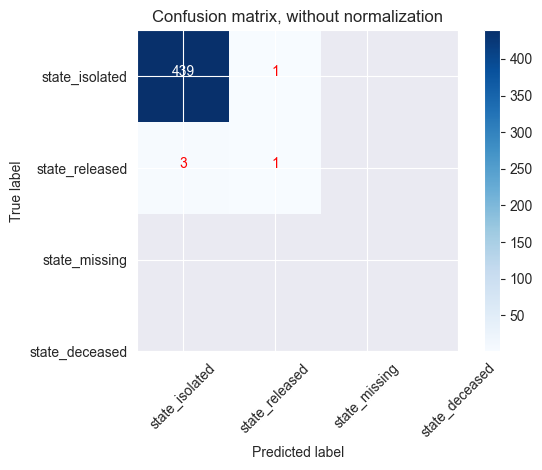

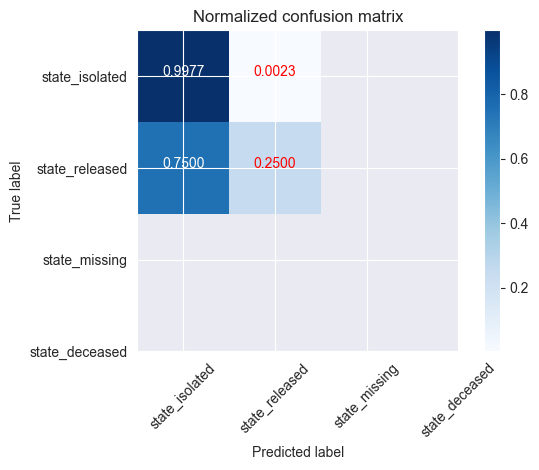

In [86]:
# Use classes_names2
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=6)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names2,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names2, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


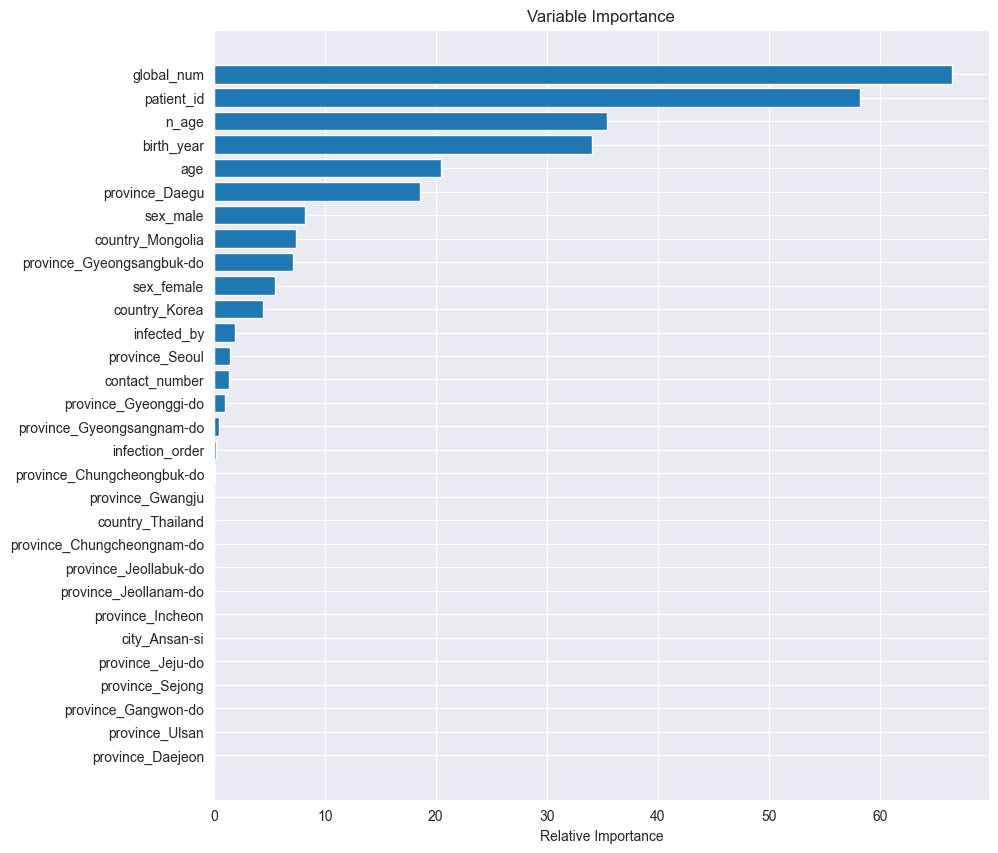

In [87]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.